# Retrieval Augmented Diffusion Multimodal Model for Time-Series Forecasting

Authors: </br>
Valerio Baldi 1940729 </br>
Saverio Dieni 1946039 </br>

Selected paper: **Retrieval-Augmented Diffusion Models for Time Series Forecasting**

# References

Papers: <br/>[**Retrieval-Augmented Diffusion Models for Time Series Forecasting**](https://openreview.net/pdf?id=dRJJt0Ji48)<br/>
[**HouseTS: A Large-Scale, Multimodal
Spatiotemporal U.S. Housing Dataset**](https://arxiv.org/pdf/2506.00765) <br/>
Dataset: [**HouseTS Dataset from Kaggle**](https://www.kaggle.com/datasets/shengkunwang/housets-dataset) <br/>
Notebook: model.ipynb

# Project aim and paper description

This notebook aims to extend the previous notebook on Retrieval Augmented Diffusion Model for Time-Series Forecasting, introducing multimodality to retrieve extra information from the satellite photos provided in the HouseTS dataset. <br/>
In the paper HouseTS: A Large-Scale, Multimodal
Spatiotemporal U.S. Housing Dataset, the authors tried to leverage the additional images to improve the prediction quality. They aimed to predict the price, using raw images and/or prompts derived by the photos, using GPT-4o, that describe the changes in the zone. They found out that even though the results do not improve with respect to the ones obtained by the plain time-series prediction model. <br/>
For our scope we decided to combine the RATD model with embeddings extracted from the images, using the CLIP encoder.

# Theoretical background and key concepts

For each time-series taken by the model we also previded an image. For the input time-series, the one to predict, we provided the satellite image taken at the begine of the series, while for each reference we used the image taken at the end of the series. Then, from each image we extracted an embedding using the CLIP encoder.
These embeddings are used for FiLM (Feature-wise Linear Modulation), where each time-series is scaled and shifted by two parameters.
Formally, FiLM is formulated as:

$$
\text{FiLM}(x \mid \gamma, \beta) = \gamma \odot x + \beta
$$

where gamma and beta are 2 modulation parameters, and are the result of a function, expressed as a neural network with parameters $\theta$, of an embedding y:

$$
concat(\gamma, \beta)= f_\theta(y)
$$

# Reproducibility

We both launched this notebook on our machines and on Kaggle notebooks. Before starting the process is required to import all the modules defined in the import section. It is also necessary to have available the auto-encoder for housets defined in the notebook "autoencoder_for_housets.ipynb". You can direclty find the pre-trained auto-encoder model in the folder "models", with the name "encoder.pth".

# Import

In [1]:
pip install faiss-cpu


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install transformers


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install linear-attention-transformer

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
import torch.nn as nn
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from linear_attention_transformer import LinearAttentionTransformer
import math 
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import resnet50
from PIL import Image
import faiss
import random
from transformers import CLIPModel, CLIPProcessor
from sklearn.utils import shuffle

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # conflict between faiss and pytorch libraries 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data extraction and preprocessing

In this section we extract the time series from the CSV file. <br/>
The original dataset contains entries of the form <date, median_sale_price, median_list_price, median_ppsf, median_list_ppsf, homes_sold, pending_sales, new_listings, inventory, median_dom, avg_sale_to_list, sold_above_list, off_market_in_two_weeks, city, zipcode, year, bank, bus, hospital, mall, park, restaurant, school, station, supermarket, Total Population, Median Age, Per Capita Income, Total Families Below Poverty, Total Housing Units, Median Rent,Median Home Value, Total Labor Force, Unemployed Population, Total School Age Population, Total School Enrollment, Median Commute Time, price, city_full>, where the combination of <zipcode, year> is a key for the dataset. 
The HouseTS dataset contains also satellite images, grouped by zipocode in different folders. For this reason we decided to keep only the entries relative to zones linked to images. 
The zipcode is a representative value for each zone of Washington.</br>
We extract time series of length of 24 steps (24 months), where our final aim is to predict the last 12 timesteps given the previous 12s. </br>
As preprocessing we dropped non relevant features in this simplified scenario, and we also extracted metadata: zipcode, start_timestamp, end_timestamp, start_year, end_year.  

In [19]:
window_length = 24 # 12 known timesteps, the last 12 timestemps to be predicted
step_size = 1

In [20]:
csv_file = "HouseTS_with_images.csv"
df = pd.read_csv(csv_file)

df = df.drop(columns=['city', 'city_full'])

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['zipcode', 'date']).reset_index(drop=True)

feature_columns = [col for col in df.columns if col not in ['date', 'zipcode', 'year']]
feature_index_mapping = {i: col for i, col in enumerate(feature_columns)}

print("Feature index mapping:")
print(feature_index_mapping)

all_windows = []
all_meta = []

def extract_windows(df_sub, window_len, step):
    windows = []
    for i in range(0, len(df_sub) - window_len + 1, step):
        window = df_sub.iloc[i:i+window_len].drop(columns=['date', 'zipcode', 'year']).values
        windows.append(window)
    return np.array(windows)

# Group by zipcode
for zipcode, group in df.groupby('zipcode'):
    group = group.reset_index(drop=True)
    if len(group) < window_length:
        continue

    windows = extract_windows(group, window_length, step_size)
    all_windows.append(windows)

    # Save Metadata: zipcode, start and end date, start and end yera
    window_meta = [
        (
            zipcode,
            group.loc[i, 'date'],                      # start date
            group.loc[i + window_length - 1, 'date'],  # end date
            group.loc[i, 'year'],                      # start year
            group.loc[i + window_length - 1, 'year']   # end year
        )
        for i in range(len(group) - window_length + 1)
    ]
    all_meta.extend(window_meta)

# Concatenate all the windows
X = np.vstack(all_windows)  # shape: (num_samples, window_length, num_features)

print("Shape of X:", X.shape)
print("Number of metadata entries:", len(all_meta))

print("Metadata example:", all_meta[0])

Feature index mapping:
{0: 'median_sale_price', 1: 'median_list_price', 2: 'median_ppsf', 3: 'median_list_ppsf', 4: 'homes_sold', 5: 'pending_sales', 6: 'new_listings', 7: 'inventory', 8: 'median_dom', 9: 'avg_sale_to_list', 10: 'sold_above_list', 11: 'off_market_in_two_weeks', 12: 'bank', 13: 'bus', 14: 'hospital', 15: 'mall', 16: 'park', 17: 'restaurant', 18: 'school', 19: 'station', 20: 'supermarket', 21: 'Total Population', 22: 'Median Age', 23: 'Per Capita Income', 24: 'Total Families Below Poverty', 25: 'Total Housing Units', 26: 'Median Rent', 27: 'Median Home Value', 28: 'Total Labor Force', 29: 'Unemployed Population', 30: 'Total School Age Population', 31: 'Total School Enrollment', 32: 'Median Commute Time', 33: 'price'}
Shape of X: (36652, 24, 34)
Number of metadata entries: 36652
Metadata example: (20001, Timestamp('2012-03-31 00:00:00'), Timestamp('2014-02-28 00:00:00'), 2012, 2014)


We shuffled the dataset fixing the seed for replication purposes, then we splitted the dtaset for the training, evaluation and testing, respectively with a proportion 70%, 10% 20%. We normalized the datasets, according to the training dataset. Finally we created the DataLoaders, with a batch size of 32. 

In [ ]:
X, all_meta = shuffle(X, all_meta, random_state=626)

train_size = int(0.7 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

X_train = X[:train_size]
X_val = X[train_size:train_size + val_size]
X_test = X[train_size + val_size:]

meta_train = all_meta[:train_size]
meta_val = all_meta[train_size:train_size + val_size]
meta_test = all_meta[train_size + val_size:]

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, meta, seq_len=None):
        self.X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        self.meta = meta  # [(zipcode, start_date, end_date, start_year, end_year)]
        self.seq_len = seq_len or X.shape[1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # shape: (seq_len, num_features)
        
        zipcode, start_date, end_date, start_year, end_year = self.meta[idx]

        # Build UNIX timestamps for every month
        dates = pd.date_range(start=start_date, end=end_date, periods=self.seq_len)
        timestamps = torch.tensor([int(d.timestamp()) for d in dates], dtype=torch.long)

        # Extract the years
        years = torch.tensor([d.year for d in dates], dtype=torch.long)

        return x, timestamps, zipcode, years


In [23]:
# Compute the statistics of the train dataset and normalize with respect to it 
mean = X_train.mean(axis=(0, 1), keepdims=True)  # shape (1, 1, num_features)
std = X_train.std(axis=(0, 1), keepdims=True)

X_train_norm = (X_train - mean) / std
X_val_norm = (X_val - mean) / std
X_test_norm = (X_test - mean) / std

train_dataset = TimeSeriesDataset(X_train_norm, meta_train)
val_dataset = TimeSeriesDataset(X_val_norm, meta_val)
test_dataset = TimeSeriesDataset(X_test_norm, meta_test)

X_train_tensor =  train_dataset.X

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Retrieval Database

We reloaded the pre-trained encoder-decoder to embed the train dataset and build an efficient retrieval database for top k nearest neighbours search. 

In [24]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size] if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation  # full causal
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)

        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)

        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.relu1, self.dropout1,
            self.conv2, self.chomp2, self.relu2, self.dropout2,
        )

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x if self.downsample is None else self.downsample(x)
        out = self.net(x)
        if out.shape != res.shape:
            # Align time dimension by cropping the residual (this might be necessary in some edge cases)
            min_len = min(out.size(-1), res.size(-1))
            out = out[..., :min_len]
            res = res[..., :min_len]
        return self.relu(out + res)


In [25]:
# Encoder
class TCNEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_dim if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation, dropout))
        self.tcn = nn.Sequential(*layers)

        # Projection from [B, C, T] to [B, emb_dim]
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.project = nn.Linear(num_channels[-1], emb_dim)

    def forward(self, x):
        # x: [B, T, D] → [B, D, T]
        x = x.permute(0, 2, 1)
        x = self.tcn(x)  # [B, C, T]
        x = self.pool(x).squeeze(-1)  # [B, C]
        x = self.project(x)  # [B, emb_dim]
        return x

# Decoder
class TCNDecoder(nn.Module):
    def __init__(self, emb_dim, output_dim, seq_len, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        self.seq_len = seq_len
        self.output_dim = output_dim

        # Project embedding back to a sequence shape: [B, C, T]
        self.expand = nn.Linear(emb_dim, num_channels[0] * seq_len)

        layers = []
        for i in range(len(num_channels) - 1):
            in_ch = num_channels[i]
            out_ch = num_channels[i + 1]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation, dropout))

        self.tcn = nn.Sequential(*layers)
        self.out_proj = nn.Conv1d(num_channels[-1], output_dim, kernel_size=1)

    def forward(self, x):
        # x: [B, emb_dim] → [B, C0, T]
        x = self.expand(x)  # [B, C0 * T]
        x = x.view(x.size(0), -1, self.seq_len)  # [B, C0, T]
        x = self.tcn(x)  # [B, Cn, T]
        x = self.out_proj(x)  # [B, D, T]
        return x.permute(0, 2, 1)  # [B, T, D]

In [26]:
class TCNAutoencoder(nn.Module):
    def __init__(self, input_dim, emb_dim, seq_len, channels, kernel_size=3, dropout=0.2):
        super().__init__()
        self.encoder = TCNEncoder(input_dim, emb_dim, channels, kernel_size, dropout)
        self.decoder = TCNDecoder(emb_dim, input_dim, seq_len, channels[::-1], kernel_size, dropout)

    def forward(self, x, only_encoder = False):
        # x: [B, T, D]
        z = self.encoder(x)       # [B, emb_dim]
        if only_encoder:
            return z
        x_recon = self.decoder(z) # [B, T, D]
        return x_recon


In [27]:
encoder_path = "models/encoder.pth"
T, D = 12, 34
emb_dim = 64
channels = [32, 64, 128]

encoder_loaded = TCNAutoencoder(input_dim=D, emb_dim=emb_dim, seq_len=T, channels=channels)

encoder_loaded.load_state_dict(torch.load(encoder_path, map_location=device))

encoder_loaded.to(device)

encoder_loaded.eval()

print("Models reloaded successfully.")

Models reloaded successfully.


C:\Users\saver\AppData\Local\Temp\ipykernel_31240\3833310308.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_loaded.load_state_dict(torch.load(encoder_path, map_

As indicated in the paper, we build the retrieval database starting from the train dataset. In particular for each time series in the train dataset, the retrieval database DR_emb contains a couple (embedding, target), where embedding is obtained as the result of the encoder on the head of the series, in our case we consider the first 12 timesteps, and the target is simply the tail of the series, in our case of length 12. In this case we extended the retrieval database DR_emb by adding also the metadata, used to retrieve the appropriate image for the time-series. </br>
We want to use the retrieval database Dr_emb to find the top k nearest neighbours, to use as a reference for the prediction model. At this purpose we indexed the database using the FAISS implementation, which is very effective for large datasets, so to search fast even increasing the number of samples.  

In [28]:
@torch.no_grad()
def build_retrieval_database(dataset, meta, encoder, n, h, device):
    """
    Build the retrieval database DR_emb as a list of tuples (embedding, target).
    
    Args:
        dataset: tensor (N, n+h, D)
        encoder: pre-trained model
        n: head of the sequence
        h: len of the target

    Returns:
        List of tuples: [(embedding_i, target_i, zipcode_i, end_year_i)]
    """
    encoder.eval()
    dataset = dataset.to(device)
    emb_list = []
    for i in range(dataset.shape[0]):
        x = dataset[i:i+1, :n, :]        # (1, n, D)
        y = dataset[i, n:n+h, :].clone() # (h, D)
        emb = encoder(x, only_encoder = True)                 # (1, embedding_dim)
        emb_list.append((emb.squeeze(0).cpu(), y.cpu(), meta[i][0], meta[i][-1]))
    return emb_list


In [29]:
def build_faiss_index(retrieval_db, use_gpu=False):
    """
    Build FAISS index and return targets + metadata (zip/year).
    """
    embeddings = torch.stack([emb for (emb, _, _, _) in retrieval_db])  # (N, embdim)
    targets = torch.stack([tgt for (_, tgt, _, _) in retrieval_db])     # (N, h, D)
    zipcodes = [zip_ for (_, _, zip_, _) in retrieval_db]
    years = [year for (_, _, _, year) in retrieval_db]

    emb_dim = embeddings.shape[1]
    embeddings_np = embeddings.numpy().astype('float32')

    index = faiss.IndexFlatL2(emb_dim)
    if use_gpu:
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0, index)

    index.add(embeddings_np)
    return index, targets, zipcodes, years


In [30]:
def retrieve_knn(xH, encoder, faiss_index, targets_db, zipcodes_db, years_db, k, device):
    """
    Args:
        xH: (B, n, D)
        ...
    Returns:
        xR: (B, k, h, D)
        zipR: (B, k)
        yearR: (B, k)
    """
    encoder.eval()
    with torch.no_grad():
        vH = encoder(xH.to(device), only_encoder=True)  # (B, emb_dim)

    vHnp = vH.cpu().numpy().astype('float32')
    _, indices = faiss_index.search(vHnp, k)  # (B, k)

    indices_torch = torch.from_numpy(indices)  # (B, k)
    xR = targets_db[indices_torch]  # (B, k, h, D)

    zipR = [[zipcodes_db[idx] for idx in row] for row in indices]
    yearR = [[years_db[idx] for idx in row] for row in indices]

    zipR = torch.tensor(zipR, dtype=torch.int)
    yearR = torch.tensor(yearR, dtype=torch.int)
    
    return xR, zipR, yearR

In [31]:
for p in encoder_loaded.parameters():
    p.requires_grad = False

retrieval_db = build_retrieval_database(X_train_tensor, meta_train, 
                                        encoder_loaded, n=12, h=12, device=device)
faiss_index, xr_target, xr_zipcodes_db, xr_years_db = build_faiss_index(retrieval_db)

# Image loading

In this section we loaded the images from the appropriate folder. Images are grouped by zipcodes and every satellite image is named with its own year. The dataset does not contain all the images for all the years covered by the time-series (from 2012 to 2023). In this section we also defined the functions and data structures used to retrieve the correct image for a combination of zipocode and year, and if an image is missing for some year we used the last available photo.

In [ ]:
IMG_ROOT = "DMV_Multi_Data/DMV_Multi_Data"
IMG_SIZE = 224
IMG_EXTS = {".jpg", ".jpeg", ".png", ".webp"}
PREPROCESSED_ROOT = "preprocessed_images"  # path where the pre-computed tensors are stored

# Transformations
img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

os.makedirs(PREPROCESSED_ROOT, exist_ok=True)

# Cache in RAM (dictionary)
_img_cache = {}

def _list_years_for_zip(zipcode: int):
    dir_path = os.path.join(IMG_ROOT, str(zipcode))
    if not os.path.isdir(dir_path):
        return []
    out = []
    for fname in os.listdir(dir_path):
        base, ext = os.path.splitext(fname)
        if ext.lower() in IMG_EXTS and base.isdigit():
            out.append((int(base), os.path.join(dir_path, fname)))
    return sorted(out, key=lambda x: x[0])

def _get_preprocessed_path(zipcode: int, year: int):
    folder = os.path.join(PREPROCESSED_ROOT, str(zipcode))
    os.makedirs(folder, exist_ok=True)
    return os.path.join(folder, f"{year}.pt")

def load_image_for(zipcode: int, year: int):
    # Find the best image <= year
    entries = _list_years_for_zip(zipcode)
    candidates = [(y, p) for (y, p) in entries if y <= year]
    if not candidates:
        return torch.zeros(3, IMG_SIZE, IMG_SIZE)
    chosen_year, path = candidates[-1]

    # Check if it is already inside the RAM
    cache_key = (zipcode, chosen_year)
    if cache_key in _img_cache:
        return _img_cache[cache_key]

    preproc_path = _get_preprocessed_path(zipcode, chosen_year)
    if os.path.isfile(preproc_path):
        img_tensor = torch.load(preproc_path)
    else:
        # Save the pre-computed tensors if it is new
        img = Image.open(path).convert("RGB")
        img_tensor = img_transform(img)
        torch.save(img_tensor, preproc_path)

    _img_cache[cache_key] = img_tensor
    return img_tensor

def get_img_tensors_batch_from_dirs(zipcodes, years):
    zip_list = zipcodes.tolist() if torch.is_tensor(zipcodes) else zipcodes
    yr_list  = years.tolist()    if torch.is_tensor(years)    else years

    imgs = []
    for z, y in zip(zip_list, yr_list):
        z_i = int(z) if not isinstance(z, list) else int(z[0])
        y_i = int(y) if not isinstance(y, list) else int(y[0])
        imgs.append(load_image_for(z_i, y_i))
    return torch.stack(imgs)

def get_k_img_tensors_batch_from_dirs(zipcodes, years):
    zipcodes = zipcodes.tolist() if torch.is_tensor(zipcodes) else zipcodes
    years    = years.tolist()    if torch.is_tensor(years)    else years

    B, K = len(zipcodes), len(zipcodes[0])
    out = torch.empty((B, K, 3, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
    for b in range(B):
        for k in range(K):
            z, y = zipcodes[b][k], years[b][k]
            out[b,k] = load_image_for(int(z), int(y))
    return out


# Model

In this section we developed the RATD model according to the descriptions and the graphical representations reported in the paper.</br> </br>
<img src="ratd_architecture.png"> </br></br>
We started from the implementation of the module regarding the side information (time embeddings + feature embeddings) and the diffusion timestep embeddings. 
Then we implemented the other blocks lik the RMA (Reference Modulated Attention) module, the Time and the Feature Tranformers, starting from the implementation provived by LinearAttentionTransformer, and finally the GAU (Gated Activation Unit) module. </br>
We composed all together these blocks in the module RATDLayer, that includes all the computations done in a single step of the model. Lastly we implemented the full RATD model, by stacking the layers and applying additonal computations adding the noise to the input, initializing the side information and the diffiusion timestep embedding, and finally processing the results of each layer.    

In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [34]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            dilation=dilation
        )

    def forward(self, x):
        # x shape: (batch, channels, seq_len)
        pad = (self.kernel_size - 1) * self.dilation
        x = F.pad(x, (pad, 0))  # pad left only
        return self.conv(x)

In [ ]:
class SideInformation(nn.Module):
    def __init__(self, num_features: int, time_dim: int = 32, feat_dim: int = 16, base: int = 10000):
        """
        time_dim: dimension of the sinusoidal time embeddings
        feat_dim: dimension of the feature embeddings
        """
        super().__init__()
        self.num_features = num_features
        self.time_dim = time_dim
        self.feat_dim = feat_dim
        self.total_dim = time_dim + feat_dim
        self.base = base

        # Learnable feature embedding: (num_features, feat_dim)
        self.feature_embedding = nn.Parameter(torch.randn(num_features, feat_dim))

    def forward(self, timestamps: torch.Tensor) -> torch.Tensor:
        """
        timestamps: (batch, seq_len)
        Returns:
            side_info Is: (batch, total_dim, seq_len, num_features)
        """
        batch_size, seq_len = timestamps.shape
        device = timestamps.device

        # Temporal sinusoidal embedding 
        positions = timestamps.float().unsqueeze(-1)  # (batch, seq_len, 1)
        div_term = torch.exp(
            torch.arange(0, self.time_dim, 2, device=device) * -(np.log(self.base) / self.time_dim)
        )  # (time_dim/2,)
        sin_embed = torch.sin(positions * div_term)  # (batch, seq_len, time_dim/2)
        cos_embed = torch.cos(positions * div_term)  # (batch, seq_len, time_dim/2)
        time_emb = torch.cat([sin_embed, cos_embed], dim=-1)  # (batch, seq_len, time_dim)

        # Feature embedding learnable 
        feat_emb = self.feature_embedding.unsqueeze(0).unsqueeze(0)  # (1, 1, num_features, feat_dim)
        feat_emb = feat_emb.expand(batch_size, seq_len, -1, -1)      # (batch, seq_len, num_features, feat_dim)

        # Expand time embedding to match num_features 
        time_emb = time_emb.unsqueeze(2).expand(-1, -1, self.num_features, -1)  # (batch, seq_len, num_features, time_dim)

        # Concatenate 
        side_info = torch.cat([time_emb, feat_emb], dim=-1)  # (batch, seq_len, num_features, total_dim)

        # Permute: (batch, total_dim, seq_len, num_features)
        side_info = side_info.permute(0, 3, 1, 2)

        return side_info  # Is


The RMA module was built following the structure provided in the paper, as shown in the image below:</br></br>
<img src="RMA_module.png"></br></br>
The module use attention on the references and on the side information to guide the generation process.

In [ ]:
class RMA(nn.Module): 
    def __init__(self, input_dim, inner_dim=16):
        super().__init__()
        self.q_proj = nn.Linear(input_dim, inner_dim)
        self.k_proj = nn.Linear(2 * input_dim, inner_dim)
        self.v_proj = nn.Linear(3 * input_dim, inner_dim)
        self.out = nn.Linear(inner_dim, input_dim)

    def forward(self, x, xr, side_info, causal = False):
        """
        x:         (B, C, T, D)
        xr:        (B, C, T, D)
        side_info: (B, C, T, D)
        Returns:
        Z: (B, C, T, D)
        """
        B, C, T, D = x.shape
        K = xr.shape[1]
        S = side_info.shape[1]

        if causal:
            # Causal mask: only x_{<t}, exclude x_t itself
            mask = torch.tril(torch.ones(T, T, device=x.device), diagonal=-1)  # (T, T)
        
            # Reshape for matmul: (B, C, D, T)
            x = x.permute(0, 1, 3, 2)  # (B, C, D, T)
        
            # Apply mask: (B, C, D, T) x (T, T) -> (B, C, D, T)
            x = torch.matmul(x, mask)  # each t gets sum of x_{<t}
        
            # Reshape back to (B, C, T, D)
            x = x.permute(0, 1, 3, 2)


        # 1. Concat references and side_info: (B, C, T, D)
        k_input = torch.cat([xr, side_info], dim=-1)
        v_input = torch.cat([x, k_input], dim=-1)

        # 2. Linear projections
        Q = self.q_proj(x)  # (B, C, T, D_inner)
        K_proj = self.k_proj(k_input)  # (B, C, T, D_inner)
        V_proj = self.v_proj(v_input)  # (B, C, T, D_inner)

        # 3. Rearrange K and V for matmul
        # shape: (B, T, C, D_inner)
        K_flat = K_proj.permute(0, 2, 1, 3)
        V_flat = V_proj.permute(0, 2, 1, 3).reshape(B*T, C, V_proj.shape[-1])

        # 4. Attention computation
        # softmax over C dimension (i.e., across references + side info)
        A = torch.softmax(K_flat, dim=2)  # (B, T, C, D_inner)

        # compute A^T V: (B*T, D_inner, C) X (B*T, C, D_inner)
        A_T = A.permute(0, 1, 3, 2).reshape(B*T, A.shape[-1], C)  # (B*T, D_inner, C) 
        attn_matrix = torch.bmm(A_T, V_flat)  # (B*T, D_inner, D_inner)

        # 5. Q × A: (B*C, T, D_inner) x (B*T, D_inner, D_inner)
        Q = Q.permute(0, 2, 1, 3).reshape(B*T, C, Q.shape[-1])  # (B*T, C, D_inner)
        Z = torch.bmm(Q, attn_matrix)  # (B*T, C, D_inner)

        Z = self.out(Z) # (B*T, C, D)

        # Rearrange back: (B, C, T, D)
        Z = Z.reshape(B, T, C, Z.shape[-1]).permute(0, 2, 1, 3)

        return Z, attn_matrix


In [ ]:
# test modules

B, T, D = 32, 12, 34
C = 16
K = 3
side_module = SideInformation(num_features=D)
timestamps = torch.randint(18000, 20000, (B, T))
side_info = side_module(timestamps)  # (B, 48, T, D)

x = torch.randn(B, C, T, D)
xr = torch.randn(B, C, T, D)
side_info = torch.randn(B, C, T, D)

rma = RMA(input_dim=D)

out = rma(x, xr, side_info, causal=True)[0]

print("Output shape:", out.shape)  # (B, T, inner_dim)

Output shape: torch.Size([32, 16, 12, 34])


In [38]:
class TemporalTransformer(nn.Module):
    def __init__(self, d_model=128, n_heads=2):
        super().__init__()
        self.transformer = LinearAttentionTransformer(
            dim=d_model,
            depth=1,
            heads=n_heads,
            max_seq_len = 256,
            causal = True
        )

    def forward(self, x):
        # x: (B, C, T, D)
        B, C, T, D = x.shape
        # Permute and reshape
        x = x.permute(0, 2, 1, 3).reshape(B * T, C, D) # (B * T, C, D)
        # Permute, apply the transformation and then permute back
        x = self.transformer(x.permute(0, 2, 1)).permute(0, 2, 1) # (B * T, C, D)
        # Reshape and permute to return to the original shape
        x = x.reshape(B, T, C, D).permute(0, 2, 1, 3) # (B, C, T, D)
        return x


In [39]:
class FeatureTransformer(nn.Module):
    def __init__(self, d_model=128, n_heads=2):
        super().__init__()
        self.transformer = LinearAttentionTransformer(
            dim=d_model,
            depth=1,
            heads=n_heads,
            max_seq_len = 256,
            causal = True
        )

    def forward(self, x):
        # x: (B, C, T, D)
        B, C, T, D = x.shape
        # Permute and reshape
        x = x.permute(0, 3, 1, 2).reshape(B * D, C, T) # (B * D, C, T)
        # Permute, apply the transformation and then permute back
        x = self.transformer(x.permute(0, 2, 1)).permute(0, 2, 1) # (B * T, C, D)
        # Reshape and permute to return to the original shape
        x = x.reshape(B, D, C, T).permute(0, 2, 3, 1) # (B, C, T, D)
        return x


In [40]:
class LearnableDiffusionTimestepEmbedding(nn.Module):
    def __init__(self, num_timesteps: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_timesteps, embedding_dim)

    def forward(self, timesteps: torch.Tensor):
        """
        timesteps: (n_layers,) tensors of integers ∈ [0, num_timesteps)
        """
        return self.embedding(timesteps)  # (n_layers, embedding_dim)


In [41]:
# Gated Activation Unit
class GAU(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.projection = CausalConv1d(channels, 2 * channels, kernel_size=3)

    def forward(self, x):
        """"
        input: x (B, C, D)
        output: x (B, C, D)
        """
        # Doubling the number of channels 
        x = self.projection(x)  # (B, 2*C, D)
        # Split x in 2 chunchs
        gate, filter = torch.chunk(x, 2, dim=1)  # each of them with shape (B, C, D)
        # Gate the result
        x = torch.sigmoid(gate) * torch.tanh(filter)  # (B, C, D)
        return x

In [ ]:
class RATDLayer(nn.Module):
    def __init__(self, input_dim, channels, seq_len, context_dim, side_dim, emb_dim, img_emb_dim = None):
        super().__init__()
        self.img_emb_dim = img_emb_dim
        # Visual conditioning (FiLM)
        if img_emb_dim is not None:
            self.film_ln = nn.LayerNorm(img_emb_dim)
            self.film_conv = CausalConv1d(1, channels, kernel_size=1)
            self.film_fc = nn.Linear(img_emb_dim, seq_len * input_dim * 2)
            nn.init.zeros_(self.film_fc.weight)
            nn.init.constant_(self.film_fc.bias[:input_dim * seq_len], 1.0)  # gamma = 1
            nn.init.constant_(self.film_fc.bias[input_dim * seq_len:], 0.0)  # beta = 0
        else:
            self.film_ln = None
            self.film_conv = None
            self.film_fc = None

        self.channels = channels
        self.context_dim = context_dim
        self.side_dim = side_dim
        self.emb_dim = emb_dim
        self.rma = RMA(input_dim=input_dim)
        self.time_feature_conv = CausalConv1d(side_dim * seq_len, channels * seq_len, kernel_size=3)
        self.diff_timestep_emb_conv = CausalConv1d(emb_dim, channels * seq_len, kernel_size=3)
        self.ln = nn.LayerNorm((channels, seq_len, input_dim))
        self.temporal_transformer = TemporalTransformer(d_model=channels)
        self.feature_transformer = FeatureTransformer(d_model=channels)
        self.gau = GAU(channels * seq_len)
        self.conv_out1 = CausalConv1d(channels * seq_len, channels * seq_len, kernel_size=3)
        self.conv_out2 = CausalConv1d(channels * seq_len, channels * seq_len, kernel_size=3)

    def forward(self, x, xr, side_info, diff_emb, img_emb = None):
        """
        x: (B, C, T, D) 
        xr: (B, C, T, D)
        side_info: (B, side_dim, T, D)
        diff_emb: (B, emb_dim, 1)
        """
        B, C, T, D = x.shape
        K = self.context_dim
        side_dim = self.side_dim

        res_x = x.reshape(B, C*T, D) 

        # Apply FiLM modulation to x
        if self.film_fc is not None and img_emb is not None:
            img_emb = img_emb.unsqueeze(1)  # [B, 1, emb_dim]
            gamma_beta = self.film_fc(self.film_conv(self.film_ln(img_emb)))  # [B, C, 2*T*D]
            gamma, beta = gamma_beta.chunk(2, dim=-1)  # Each: [B, C, T*D]
            gamma = gamma.view(B, C, T, D)
            beta = beta.view(B, C, T, D)
            x = gamma * x + beta  # (B, C, T, D)

        diff_emb = self.diff_timestep_emb_conv(diff_emb) # (B, C, 1)
        x = (x.reshape(B, C*T, D) + diff_emb).reshape(B, C, T, D) # (B, C, T, D)
        side_info = side_info.reshape(B, side_dim*T, D) # (B, side_dim*T, D)
        side_info = self.time_feature_conv(side_info) # (B, C*T, D)
        side_info = side_info.reshape(B, C, T, D)
        res_side_info = side_info
        x = self.rma(x, xr, side_info, causal = True)[0] # (B, C, T, D)
        x = self.ln(x)
        x = self.temporal_transformer(x) # (B, C, T, D)
        x = self.ln(x)
        x = self.feature_transformer(x) # (B, C, T, D)
        x = x + res_side_info
        x = self.ln(x)
        x = x.reshape(B, C*T, D)
        x = self.gau(x)
        y = x 
        x = self.conv_out1(x) + res_x # (B, C*T, D)
        x = x.reshape(B, C, T, D)
        x = self.ln(x)
        y = self.conv_out2(y) # (B, C*T, D)

        return x, y

In [ ]:
# test
B, T, D = 32, 12, 34
C = 16
K = 3
emb_dim = 64
x = torch.randn(B, C, T, D)
xr = torch.randn(B, C, T, D)
side_info = torch.randn(B, 48, T, D)
lfte = LearnableDiffusionTimestepEmbedding(num_timesteps=T, embedding_dim=emb_dim)

timesteps = torch.randint(0, T, (B,), dtype=torch.long)
emb = lfte(timesteps).unsqueeze(-1)  # (B, emb_dim, 1)
print(emb.shape)
ratdlayer = RATDLayer(D, C, T, K, 48, emb_dim)
x, y = ratdlayer(x, xr, side_info, emb)
    
print("Output x.shape:", x.shape)
print("Output y.shape:", y.shape)

torch.Size([32, 64, 1])
Output x.shape: torch.Size([32, 16, 12, 34])
Output y.shape: torch.Size([32, 192, 34])


In [44]:
print(f"RATDLayer parameters: {count_parameters(ratdlayer):,}")

RATDLayer parameters: 835,570


In [ ]:
class RATD(nn.Module):
    def __init__(self, input_dim, channels, context_dim, side_dim, 
                emb_dim, original_len, seq_len, n_layers = 5, img_emb_dim = 2048):
        
        super().__init__()

        self.img_emb_dim = img_emb_dim
        # Visual conditioning (FiLM)
        if img_emb_dim is not None:
            self.xr_conv = nn.Conv1d(in_channels=context_dim, out_channels=channels, kernel_size=1)  # (B, K, E) → (B, C, E)
            self.film_ln = nn.LayerNorm(img_emb_dim)
            self.film_fc = nn.Linear(img_emb_dim, 2 * input_dim * seq_len)

            # Inizialization for FiLM
            nn.init.zeros_(self.film_fc.weight)
            nn.init.constant_(self.film_fc.bias[:input_dim * seq_len], 1.0)   # gamma = 1
            nn.init.constant_(self.film_fc.bias[input_dim * seq_len:], 0.0)   # beta = 0
        else:
            self.xr_conv = None
            self.film_ln = None
            self.film_fc = None

        self.channels = channels
        self.context_dim = context_dim
        self.side_dim = side_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.seq_len = seq_len
        self.original_len = original_len
        self.l = seq_len - original_len
        self.a = nn.Parameter(torch.ones(n_layers + 1, channels), requires_grad=True)
        self.t_len = 20

        mask_0 = torch.zeros((seq_len//2, input_dim))
        mask_1 = torch.ones((seq_len//2, input_dim))
        self.mask = torch.cat([mask_0, mask_1], dim = 0)
        self.cond_mask = torch.cat([mask_1, mask_0], dim = 0)

        self.input_dim = input_dim
        self.ldte = LearnableDiffusionTimestepEmbedding(num_timesteps=self.t_len, embedding_dim=emb_dim)
        self.side_module = SideInformation(num_features=input_dim)

        self.layers = nn.ModuleList(
            [ RATDLayer(input_dim, channels, seq_len, context_dim, side_dim, emb_dim, img_emb_dim) for _ in range(n_layers) ]
        )
        self.input_conv = CausalConv1d(seq_len, channels * seq_len, kernel_size=3)
        self.gelu = nn.GELU()
        self.ref_conv = CausalConv1d(context_dim * seq_len, channels * seq_len, kernel_size=3)
        self.conv_out1 = CausalConv1d(channels * seq_len, channels * seq_len, kernel_size=3)
        self.conv_out2 = CausalConv1d(channels * seq_len, seq_len, kernel_size=3)

        # Diffusion parameters
        beta_start = 0.1
        beta_end = 0.9
        self.beta = np.linspace(beta_start, beta_end, self.t_len)
        self.alpha_hat = 1 - self.beta
        self.alpha = np.cumprod(self.alpha_hat)
        self.register_buffer("alpha_torch", torch.tensor(self.alpha).float().unsqueeze(1).unsqueeze(1))
    
    def forward(self, x, xr, timestamps, t = None, x_img_emb = None, xr_img_emb = None):
        """
        x: (B, T, D) 
        xr: (B, K, l, D)
        out : (B, T, D)
        """
        B, _, D = x.shape
        C = self.channels
        K = self.context_dim
        T = self.seq_len
        original_T = T - self.l

        # Build the side_info and the diff_emb
        if t is None:
            t = torch.full((B,), self.t_len - 1, dtype=torch.long, device=x.device)
        diff_emb = self.ldte(t.to(self.ldte.embedding.weight.device))
        diff_emb = diff_emb.unsqueeze(-1)  # (B, emb_dim, 1)
         
        side_info = self.side_module(timestamps)

        # Reconstruct xr to make it of the same length of x 
        x_truncated = x[:, 0:original_T, :] # (B, original_len, D)
        x_rep = x_truncated.unsqueeze(1).repeat(1, K, 1, 1).to(xr.device)  # (B, K, original_len, D)
        xr = torch.cat([x_rep, xr], dim=2)  # (B, K, T, D)

        # Save the input for residual connections
        res_x = x[:, :original_T, :].unsqueeze(1).repeat(1, C, 1, 1)  # (B, C, T-l, D)

        x = self.gelu(self.input_conv(x)) # (B, C*T, D)
        x = x.reshape(B, C, T, D)

        xr = xr.reshape(B, K*T, D) # (B, K*T, D)
        xr = self.ref_conv(xr) # (B, C*T, D)
        xr = xr.reshape(B, C, T, D)

        # img_emb: (B, K, E)
        if self.xr_conv is not None and self.film_fc is not None and xr_img_emb is not None:
            # (B, K, E) → (B, C, E)
            xr_img_emb = self.xr_conv(xr_img_emb)  # conv over K dim
            
            # (B, C, E)
            xr_img_emb = self.film_ln(xr_img_emb)
            
            # (B, C, E) → (B, C, 2*T*D)
            g_and_b = self.film_fc(xr_img_emb)
            
            gamma, beta = g_and_b.chunk(2, dim=-1)  # each (B, C, T*D)
            gamma = gamma.view(B,C,T,D)  # (B, C, T, D)
            beta = beta.view(B,C,T,D)    # (B, C, T, D)

            # FiLM modulation
            xr = gamma * xr + beta

        b_stack = torch.empty((self.n_layers, B, C * T, D), device=x.device)
        for i, layer in enumerate(self.layers):
            x, b = layer(x, xr, side_info, diff_emb, x_img_emb)
            # Convex interpolation between the residual x and the output of the layer
            a_vec = torch.clamp(self.a[i], 0.0, 1.0)  # (C,)
            b_vec = 1.0 - a_vec                       # (C,)
            a_weight = a_vec.view(1, -1, 1, 1)
            b_weight = b_vec.view(1, -1, 1, 1)
            aux = a_weight * x[:, :, :original_T, :] + b_weight * res_x
            x = torch.cat([aux, x[:, :, original_T:, :]], dim=2)
            # Store intermediate output of the layer 
            b_stack[i] = b

        # Combine the intermediate outputs and rescale
        out = torch.sum(b_stack, dim=0) / math.sqrt(self.n_layers) # (B, C*T, D)
        
        out = self.gelu(self.conv_out1(out)) # (B, C*T, D)

        # Convex interpolation between the residual x and out
        a_vec = torch.clamp(self.a[self.n_layers], 0.0, 1.0)  # (C,)
        b_vec = 1.0 - a_vec                       # (C,)
        a_weight = a_vec.view(1, -1, 1, 1)
        b_weight = b_vec.view(1, -1, 1, 1)
        out = out.reshape(B, C, T, D)
        aux = a_weight * out[:, :, :original_T, :] + b_weight * res_x
        out = torch.cat([aux, out[:, :, original_T:, :]], dim=2)
        out = out.reshape(B, C*T, D)

        out = self.conv_out2(out)

        # Copy the head (original_T) of the time series
        if not self.training:
            out = torch.cat([res_x[:, 0, :, :].reshape(B, original_T, D), out[:, original_T:, :]], dim=1)
        
        return out

We introduced multi-modality in our model by adding a new componenet in the RATD model, to exploit the satellite images of the dataset. The new component exploited the pretrained CLIP-encoder for images followed by a fully connected layer. This component allowed us to extract an embedding from each image passed to the model as input. Then we used these embeddings to module the input time series. In particular for the input time series we retrieved the image corresponding to the beginning of the time-series, while for each series used as reference we picked the image corresponding to the end of the series. Once the embeddings are extracted from the images, we used them to module the inputs using FiLM. We modifed the previous architecture of RATD, by adding a FiLM module at the beginning of each layer. In particular we implemented FiLM as the sequence of a Layer Normalization, a convolutional layer, that reshapes the number of channels, and finally a fully connected layer. At the end the output of this sequence is used to amplify and shift the input time series, by the parameter gamma and beta:

$$
\text{FiLM}(x \mid \gamma, \beta) = \gamma \odot x + \beta
$$

Since the image embedding retrieval was very timely expensive, we decided to introduce in the model a caching mechanism to reduce the training time. We used zipcodes and years as keys since each satellite image is uniquely identified by them. However, in the cache we only stored the results provived by the CLIP-encoder, since we kept freezed their weights.

In [46]:
class IMG_Enc(nn.Module):
    def __init__(self, img_emb_dim=2048,
                 use_clip=True, 
                 freeze_img_encoder=True):
        
        super().__init__()

        self._image_cache = {} 

        self.use_clip = use_clip
        self.img_emb_dim = img_emb_dim

        # ▶ Image encoder: CLIP or ResNet50
        if use_clip:
            clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", 
                                                        trust_remote_code=True, use_safetensors=True)
            self.img_encoder = clip_model.vision_model
            self.img_encoder = self.img_encoder.to(device)
            self.img_proj = nn.Linear(768, img_emb_dim)  # CLIP base outputs 768-dim
            if freeze_img_encoder:
                for p in self.img_encoder.parameters():
                    p.requires_grad = False
        else:
            resnet = resnet50(pretrained=True)
            modules = list(resnet.children())[:-1]  # remove FC layer
            self.img_encoder = nn.Sequential(*modules)  # output: (B, 2048, 1, 1)
            self.img_proj = nn.Linear(2048, img_emb_dim)
            if freeze_img_encoder:
                for p in self.img_encoder.parameters():
                    p.requires_grad = False

    def encode_image(self, img):
        """
        img: (B, 3, 224, 224)
        returns: (B, img_emb_dim)
        """
        if self.use_clip:
            outputs = self.img_encoder(pixel_values=img).last_hidden_state  # (B, N, 768)
            cls_token = outputs[:, 0, :]  # use [CLS] token
            cached_out = cls_token
            emb = self.img_proj(cls_token)  # project to match ratd img_emb_dim
        else:
            feats = self.img_encoder(img)  # (B, 2048, 1, 1)
            emb = feats.view(feats.size(0), -1)  # (B, 2048)
            cached_out = emb
            emb = self.img_proj(emb)
        return emb, cached_out
    
    def forward(self, device, x_img=None, xr_img=None, zipcode=None, xr_zipcodes=None):
        B = x_img.shape[0]
        x_img_emb = None
        xr_img_emb = None

        # --- Prepare zip and year for x_img
        if zipcode is not None and timestamps is not None:
            years = timestamps[:, 0].tolist() if torch.is_tensor(timestamps) else timestamps[:, 0]
            zips = zipcode.tolist() if torch.is_tensor(zipcode) else zipcode
        else:
            years = [None] * B
            zips = [None] * B

        # --- Encode x_img with cache
        if x_img is not None:
            x_img_emb = torch.empty((B, self.img_emb_dim), dtype=torch.float32, device=device)
            for i in range(B):
                key = (zips[i], years[i])
                if key in self._image_cache:
                    cached_emb = self._image_cache[key].to(device)
                    x_img_emb[i] = self.img_proj(cached_emb)
                else:
                    emb, cached_out = self.encode_image(x_img[i:i+1])
                    emb, cached_out = emb.detach(), cached_out.detach()
                    self._image_cache[key] = cached_out.cpu()
                    x_img_emb[i] = emb.to(device)

        # --- Encode xr_img with cache using xr_zipcodes
        if xr_img is not None:
            B, K, C, H, W = xr_img.shape
            xr_img_emb = torch.empty((B, K, self.img_emb_dim), dtype=torch.float32, device=device)

            for b in range(B):
                for k in range(K):
                    year = timestamps[b, k].item() if torch.is_tensor(timestamps) else timestamps[b][k]
                    zip_ = None
                    if xr_zipcodes is not None:
                        zip_ = xr_zipcodes[b, k].item() if torch.is_tensor(xr_zipcodes) else xr_zipcodes[b][k]
                    key = (zip_, year) if zip_ is not None else None

                    if key is not None and key in self._image_cache:
                        cached_emb = self._image_cache[key].to(device)
                        emb = self.img_proj(cached_emb)
                    else:
                        img = xr_img[b, k].unsqueeze(0)  # (1, 3, H, W)
                        emb, cached_out = self.encode_image(img)
                        emb, cached_out = emb.detach(), cached_out.detach()
                        if key is not None:
                            self._image_cache[key] = cached_out.cpu()
                    xr_img_emb[b, k] = emb.to(device)

        return x_img_emb, xr_img_emb

In [ ]:
class FullRATD(nn.Module):
    def __init__(self, 
                 input_dim, 
                 channels, 
                 context_dim, 
                 side_dim, 
                 emb_dim, 
                 original_len, 
                 seq_len, 
                 n_layers=5, 
                 img_emb_dim=2048,
                 use_clip=True, 
                 freeze_img_encoder=True):
        super().__init__()

        self.img_enc = IMG_Enc(img_emb_dim, use_clip, freeze_img_encoder)

        # ▶ Temporal backbone
        self.ratd = RATD(
            input_dim=input_dim,
            channels=channels,
            context_dim=context_dim,
            side_dim=side_dim,
            emb_dim=emb_dim,
            original_len=original_len,
            seq_len=seq_len,
            n_layers=n_layers,
            img_emb_dim=img_emb_dim
        )

    def forward(self, x, xr, timestamps, t = None, x_img=None, xr_img=None, zipcode=None, xr_zipcodes=None):
        """
        x_img:        (B, 3, 224, 224)
        xr_img:       (B, K, 3, 224, 224)
        zipcode:      (B,)
        xr_zipcodes:  (B, K)
        """
        device = x.device

        x_img_emb, xr_img_emb = self.img_enc(device, x_img, xr_img, zipcode, xr_zipcodes)

        out = self.ratd(
            x=x,
            xr=xr,
            timestamps=timestamps,
            t=t,
            x_img_emb=x_img_emb,
            xr_img_emb=xr_img_emb
        )
        return out
    
    def calc_loss(self, x0, timestamps, xr=None, t=None):

        original_T = self.seq_len - self.l
        
        if t is None:
            # sample t uniformly at random
            t = torch.randint(0, self.t_len, (x0.shape[0],), device=x0.device)

        alpha_t = self.alpha_torch[t]

        noise = torch.randn_like(x0)
        xt = x0.detach().clone()
        # Build xt from x0, adding random nois on the tail of the series according to alpha_t
        xt[:, original_T: , :] = (alpha_t ** 0.5) * x0[:, original_T: , :] + ((1 - alpha_t) ** 0.5) * noise[:, original_T: , :]

        # Reconstruct x0 from xt
        pred = self.forward(xt, timestamps, xr, t)
        # Compute the residual
        residual = (x0 - pred) * self.mask.to(x0.device)
        num = self.mask.to(x0.device).sum()
        loss = (residual ** 2).sum() / (num if num > 0 else 1)
        return loss, pred
    
    def calc_loss_validation(self, x0, timestamps, xr=None):
        B, _, _ = x0.shape
        # Consider only the case when the tail is completly unknown
        t = torch.full((B,), self.t_len - 1, dtype=torch.long, device=x.device)
        # Compute the loss
        loss, pred = self.calc_loss(x0, timestamps, xr, t)
        loss, pred = loss.detach(), pred.detach()
        return loss, pred


In [48]:
for xb, timestamps, zipcode, year in train_loader:
  break
xb = xb.to(device)
timestamps = timestamps.to(device)

In [49]:
# test
B, orig_len, D = 32, 12, 34
K = 3
C = 16
side_dim = 48
emb_dim = 64
T = orig_len + 12

model = FullRATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T
).to(device)

print(f"FullRATD parameters: {count_parameters(model):,}")

xr, xr_zipcodes, xr_years = retrieve_knn(
    xb[:, 0:orig_len, :], 
    encoder_loaded, 
    faiss_index, 
    xr_target, 
    xr_zipcodes_db, 
    xr_years_db, 
    k=K, 
    device=device
)

xb, xr, timestamps = xb.to(device), xr.to(device), timestamps.to(device) 

x_img_tensor = get_img_tensors_batch_from_dirs(zipcode, year).to(device)

xr_img_tensor = get_k_img_tensors_batch_from_dirs(xr_zipcodes, xr_years).to(device)

output = model(
    xb,
    xr, 
    timestamps,
    None,
    x_img_tensor, 
    xr_img_tensor,
    zipcode,
    xr_zipcodes
)

assert output.shape == (B, T, D), f"Output shape mismatch: {output.shape}"
print("Test passed: output shape", output.shape)

FullRATD parameters: 38,292,594


C:\Users\saver\AppData\Local\Temp\ipykernel_31240\1396500794.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_tensor = torch.load(preproc_path)


Test passed: output shape torch.Size([32, 24, 34])


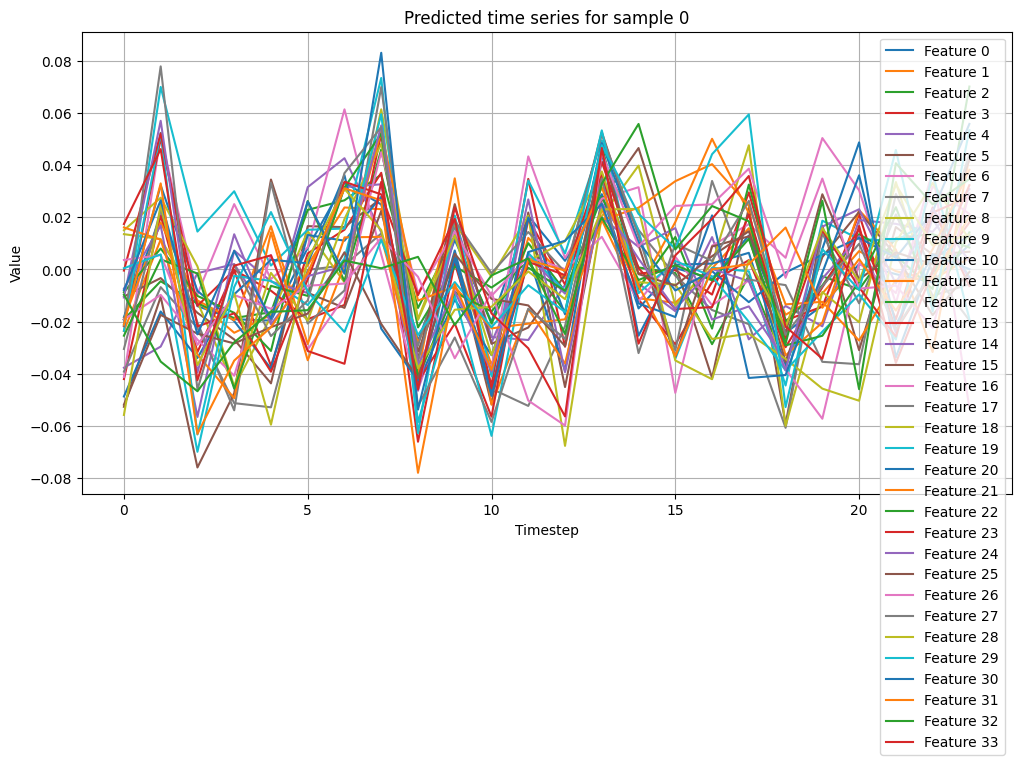

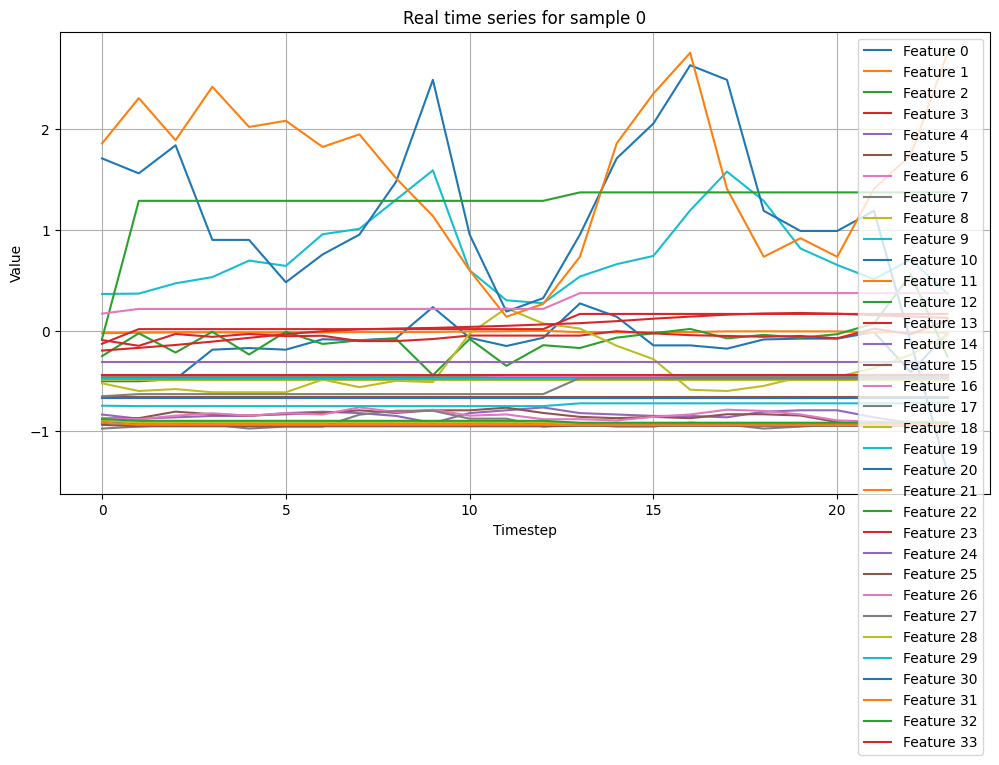

In [ ]:
# x: (B, T, D)
B, T, D = 32, 12, 34
sample_idx = 0
x_sample = output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d], label=f'Feature {d}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series for sample {sample_idx}")
plt.legend()
plt.grid(True)
plt.show()

x_sample = xb.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d], label=f'Feature {d}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Real time series for sample {sample_idx}")
plt.legend()
plt.grid(True)
plt.show()


# Training

In [ ]:
# Data augmentation functions

def jitter(x, sigma=0.01):
    noise = torch.randn_like(x) * sigma
    return x + noise

def scaling(x, scale_std=0.1):
    scale = torch.normal(mean=1.0, std=scale_std, size=(x.shape[0], 1, x.shape[2])).to(x.device)
    return x * scale

def time_stretch(x, scale_range=(0.9, 1.1)):
    B, T, C = x.size()
    scale = torch.FloatTensor(B).uniform_(*scale_range).to(x.device)
    stretched = []
    for i in range(B):
        t_len = int(T * scale[i])
        stretched_x = F.interpolate(x[i].unsqueeze(0).permute(0, 2, 1), size=t_len, mode='linear', align_corners=False)
        if t_len > T:
            stretched_x = stretched_x[:, :, :T]  # crop
        else:
            pad_len = T - t_len
            stretched_x = F.pad(stretched_x, (0, pad_len))  # pad
        stretched.append(stretched_x.permute(0, 2, 1))
    return torch.cat(stretched, dim=0)

def masking_augment_fast(x, mask_ratio=0.15, mask_value=0.0):
    mask = torch.bernoulli(torch.full(x.shape[:2], mask_ratio)).bool().to(x.device)
    x = x.clone()
    x[mask] = mask_value
    return x

In [4]:
# class to apply the data aumentations stochastically

class RandomOrderAugment:
    def __init__(self, augments):
        self.augments = augments  # List of (augment_fn, probability)

    def __call__(self, x):
        return x

augment = RandomOrderAugment([
    (jitter, 0.7),
    (scaling, 0.5),
    (time_stretch, 0.3),
    (masking_augment_fast, 0.9)
])

In [44]:
B, orig_len, D = 32, 12, 34
K = 3
C = 2
side_dim = 48
emb_dim = 16
T = orig_len + 12

model = FullRATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=3, 
    img_emb_dim=256
).to(device)

In [45]:
torch.set_flush_denormal(True)

True

In [ ]:
# training function

def train_ratd(
    model,
    train_loader,
    encoder=encoder_loaded,
    k=K,
    val_loader=None,
    orig_len=12,
    epochs=10,
    lr=1e-4,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path='multi-models/best_model.pt',
    cache_only=False,
    weight_decay=1e-5,
    early_stopping_patience=10
):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
        weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-8
    )
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    start_epoch = 1
    no_improvement_epochs = 0  # Counter for early stopping

    # === Recover Checkpoint ===
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path, map_location=device)
        model.img_enc._image_cache = checkpoint.get('image_cache', {})
        if not cache_only:
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            best_val_loss = checkpoint['best_val_loss']
            print(f"Checkpoint found. Restart from epoch {start_epoch} with best_val_loss {best_val_loss:.6f}.")

    for epoch in range(start_epoch, epochs + 1):
        model.train()
        train_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
        for x, timestamps, zipcode, year in pbar:
            # === Data Augmentation ===
            x = augment(x)
            # retrieve the top-k similar series
            xr, xr_zipcodes, xr_years = retrieve_knn(
                x[:, 0:orig_len, :], encoder, faiss_index,
                xr_target, xr_zipcodes_db, xr_years_db, k=K, device=device
            )
            # retrieve the image for the input 
            x_img_tensor = get_img_tensors_batch_from_dirs(zipcode, year).to(device)
            x, xr, timestamps = x.to(device), xr.to(device), timestamps.to(device)
            xr_zipcodes, xr_years = xr_zipcodes.to(device), xr_years.to(device)
            # retrieve the images for the references
            xr_img_tensor = get_k_img_tensors_batch_from_dirs(xr_zipcodes, xr_years).to(device)

            optimizer.zero_grad()
            loss, pred = model.calc_loss(x, xr, timestamps, None, x_img_tensor, xr_img_tensor, zipcode, xr_zipcodes)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            mse_loss = criterion(pred[:, orig_len:, :], x[:, orig_len:, :])
            train_loss += mse_loss.item()
            pbar.set_postfix(loss=mse_loss.item())

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.6f}")

        # === VALIDATION ===
        if val_loader is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for x, timestamps, zipcode, year in val_loader:
                    xr, xr_zipcodes, xr_years = retrieve_knn(
                        x[:, 0:orig_len, :], encoder, faiss_index,
                        xr_target, xr_zipcodes_db, xr_years_db, k=K, device=device
                    )
                    x_img_tensor = get_img_tensors_batch_from_dirs(zipcode, year).to(device)
                    x, xr, timestamps = x.to(device), xr.to(device), timestamps.to(device)
                    xr_zipcodes, xr_years = xr_zipcodes.to(device), xr_years.to(device)
                    xr_img_tensor = get_k_img_tensors_batch_from_dirs(xr_zipcodes, xr_years).to(device)
                    _, pred = model.calc_loss_validation(x, xr, timestamps, x_img_tensor, xr_img_tensor, zipcode, xr_zipcodes)
                    loss = criterion(pred[:, orig_len:, :], x[:, orig_len:, :])
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch {epoch}: Val Loss = {avg_val_loss:.6f}")
            scheduler.step(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                no_improvement_epochs = 0  # Reset counter
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_val_loss': best_val_loss,
                    'image_cache': model.img_enc._image_cache
                }, save_path)
                print(f"Saved best model at {save_path}")
            else:
                no_improvement_epochs += 1
                if no_improvement_epochs >= early_stopping_patience:
                    print(f"No improvement for {early_stopping_patience} epochs. Early stopping.")
                    break

In [ ]:
train_ratd(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=1e-3,
    save_path="/kaggle/working/multi-models/ratd_best.pt",
    weight_decay=5e-6,
    cache_only = True
)

Epoch 1 [Train]: 100%|██████████| 802/802 [03:36<00:00,  3.70it/s, loss=0.0999]


Epoch 1: Train Loss = 0.232429
Epoch 1: Val Loss = 0.159336
Saved best model at /kaggle/working/multi-models/ratd_best.pt


Epoch 2 [Train]: 100%|██████████| 802/802 [03:00<00:00,  4.44it/s, loss=0.025] 


Epoch 2: Train Loss = 0.123052
Epoch 2: Val Loss = 0.127533
Saved best model at /kaggle/working/multi-models/ratd_best.pt


Epoch 3 [Train]: 100%|██████████| 802/802 [02:59<00:00,  4.47it/s, loss=0.0346]


Epoch 3: Train Loss = 0.097218
Epoch 3: Val Loss = 0.112819
Saved best model at /kaggle/working/multi-models/ratd_best.pt


Epoch 4 [Train]: 100%|██████████| 802/802 [02:57<00:00,  4.52it/s, loss=0.0336]


Epoch 4: Train Loss = 0.082055
Epoch 4: Val Loss = 0.104918
Saved best model at /kaggle/working/multi-models/ratd_best.pt


Epoch 5 [Train]: 100%|██████████| 802/802 [02:57<00:00,  4.53it/s, loss=0.0412]


Epoch 5: Train Loss = 0.072374
Epoch 5: Val Loss = 0.099776
Saved best model at /kaggle/working/multi-models/ratd_best.pt


Epoch 6 [Train]: 100%|██████████| 802/802 [03:00<00:00,  4.45it/s, loss=0.0149] 


Epoch 6: Train Loss = 0.063941
Epoch 6: Val Loss = 0.095249
Saved best model at /kaggle/working/multi-models/ratd_best.pt


Epoch 7 [Train]: 100%|██████████| 802/802 [03:00<00:00,  4.44it/s, loss=0.0208] 


Epoch 7: Train Loss = 0.055901
Epoch 7: Val Loss = 0.091069
Saved best model at /kaggle/working/multi-models/ratd_best.pt


Epoch 8 [Train]: 100%|██████████| 802/802 [02:58<00:00,  4.48it/s, loss=0.0222] 


Epoch 8: Train Loss = 0.049574
Epoch 8: Val Loss = 0.088803
Saved best model at /kaggle/working/multi-models/ratd_best.pt


Epoch 9 [Train]: 100%|██████████| 802/802 [02:55<00:00,  4.57it/s, loss=0.0196] 


Epoch 9: Train Loss = 0.044885
Epoch 9: Val Loss = 0.087415
Saved best model at /kaggle/working/multi-models/ratd_best.pt


Epoch 10 [Train]: 100%|██████████| 802/802 [02:57<00:00,  4.51it/s, loss=0.0137] 


Epoch 10: Train Loss = 0.042374
Epoch 10: Val Loss = 0.085821
Saved best model at /kaggle/working/multi-models/ratd_best.pt


Epoch 11 [Train]: 100%|██████████| 802/802 [02:57<00:00,  4.51it/s, loss=0.00784]


Epoch 11: Train Loss = 0.039412
Epoch 11: Val Loss = 0.086065


Epoch 12 [Train]: 100%|██████████| 802/802 [02:56<00:00,  4.55it/s, loss=0.0167] 


Epoch 12: Train Loss = 0.036732
Epoch 12: Val Loss = 0.085139
Saved best model at /kaggle/working/multi-models/ratd_best.pt


Epoch 13 [Train]: 100%|██████████| 802/802 [02:57<00:00,  4.51it/s, loss=0.0092] 


Epoch 13: Train Loss = 0.034649
Epoch 13: Val Loss = 0.085702


Epoch 14 [Train]: 100%|██████████| 802/802 [02:57<00:00,  4.52it/s, loss=0.0204] 


Epoch 14: Train Loss = 0.032840
Epoch 14: Val Loss = 0.084745
Saved best model at /kaggle/working/multi-models/ratd_best.pt


Epoch 15 [Train]: 100%|██████████| 802/802 [03:00<00:00,  4.43it/s, loss=0.00909]


Epoch 15: Train Loss = 0.031250
Epoch 15: Val Loss = 0.083637
Saved best model at /kaggle/working/multi-models/ratd_best.pt


Epoch 16 [Train]: 100%|██████████| 802/802 [02:59<00:00,  4.46it/s, loss=0.0148] 


Epoch 16: Train Loss = 0.030031
Epoch 16: Val Loss = 0.085858


Epoch 17 [Train]: 100%|██████████| 802/802 [03:06<00:00,  4.31it/s, loss=0.00522]


Epoch 17: Train Loss = 0.028878
Epoch 17: Val Loss = 0.090133


Epoch 18 [Train]: 100%|██████████| 802/802 [03:04<00:00,  4.35it/s, loss=0.00569]


Epoch 18: Train Loss = 0.027870
Epoch 18: Val Loss = 0.083914


Epoch 19 [Train]: 100%|██████████| 802/802 [03:00<00:00,  4.43it/s, loss=0.0119] 


Epoch 19: Train Loss = 0.025402
Epoch 19: Val Loss = 0.084765


Epoch 20 [Train]: 100%|██████████| 802/802 [02:59<00:00,  4.47it/s, loss=0.0199] 


Epoch 20: Train Loss = 0.023669
Epoch 20: Val Loss = 0.085810


Epoch 21 [Train]: 100%|██████████| 802/802 [03:02<00:00,  4.40it/s, loss=0.00407]


Epoch 21: Train Loss = 0.022654
Epoch 21: Val Loss = 0.086539


Epoch 22 [Train]: 100%|██████████| 802/802 [03:01<00:00,  4.42it/s, loss=0.00548]


Epoch 22: Train Loss = 0.021263
Epoch 22: Val Loss = 0.085701


Epoch 23 [Train]: 100%|██████████| 802/802 [03:02<00:00,  4.38it/s, loss=0.00478]


Epoch 23: Train Loss = 0.020660
Epoch 23: Val Loss = 0.086683


Epoch 24 [Train]: 100%|██████████| 802/802 [03:00<00:00,  4.45it/s, loss=0.00636]


Epoch 24: Train Loss = 0.020217
Epoch 24: Val Loss = 0.088245


Epoch 25 [Train]: 100%|██████████| 802/802 [02:59<00:00,  4.47it/s, loss=0.00353]


Epoch 25: Train Loss = 0.019560
Epoch 25: Val Loss = 0.087288
No improvement for 10 epochs. Early stopping.


<img src="multi-model-train-vs-loss.png"><br/>
Since this multimodal model was heavier than the previous one we decided to add an early stopping mechanism, with a patience of 10 epochs.<br/>
The model achieved reached a slightly lower val loss with respect to the previous non-multimodal model (0.083 MSE vs 0.084 MSE).

# Results

In [51]:
B, orig_len, D = 32, 12, 34
K = 3
C = 2
side_dim = 48
emb_dim = 16
T = orig_len + 12

model = FullRATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=3, 
    img_emb_dim=256
).to(device)

In [70]:
checkpoint = torch.load("multi-models/ratd_best.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.img_enc._image_cache = checkpoint.get('image_cache', {})
model.eval()

C:\Users\saver\AppData\Local\Temp\ipykernel_31240\3176802214.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("multi-models/ratd_best.pt", map_loc

FullRATD(
  (img_enc): IMG_Enc(
    (img_encoder): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (position_embedding): Embedding(50, 768)
      )
      (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_

In [72]:
for xb, timestamps, zipcode, year in test_loader:
    break
xr, xr_zipcodes, xr_years = retrieve_knn(
    xb[:, 0:orig_len, :], 
    encoder_loaded, 
    faiss_index, 
    xr_target, 
    xr_zipcodes_db, 
    xr_years_db, 
    k=K, 
    device=device
)
x_img_tensor = get_img_tensors_batch_from_dirs(zipcode, year).to(device)
xb, xr, timestamps, xr_zipcodes, xr_years= xb.to(device), xr.to(device), timestamps.to(device), xr_zipcodes.to(device), xr_years.to(device)
xr_img_tensor = get_k_img_tensors_batch_from_dirs(xr_zipcodes, xr_years).to(device)
x_in = xb.detach().clone()
x_in[:, 12:, :] = torch.rand_like(x_in[:, 12:, :])

output = model(
    x_in,
    xr, 
    timestamps,
    None, 
    x_img_tensor, 
    xr_img_tensor,
    zipcode,
    xr_zipcodes
)

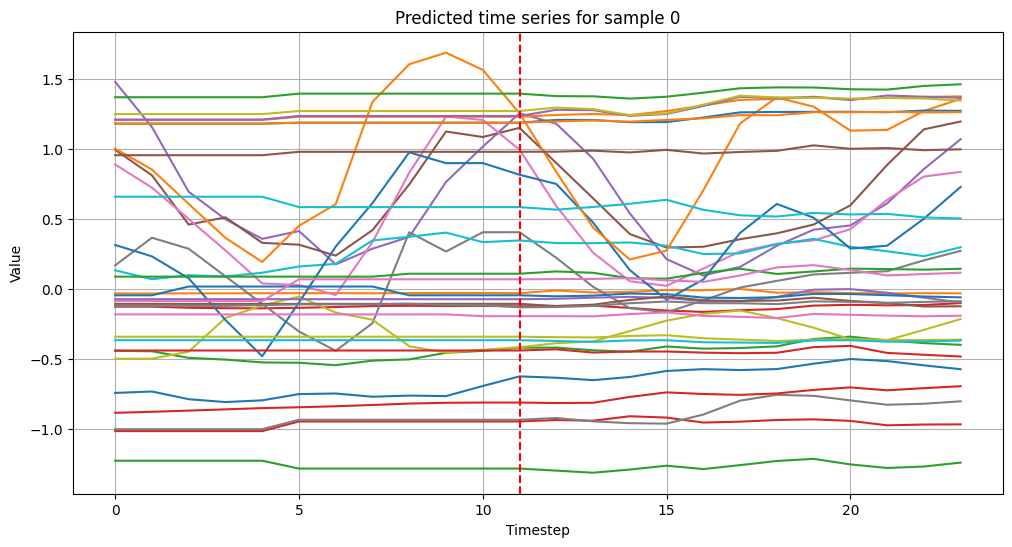

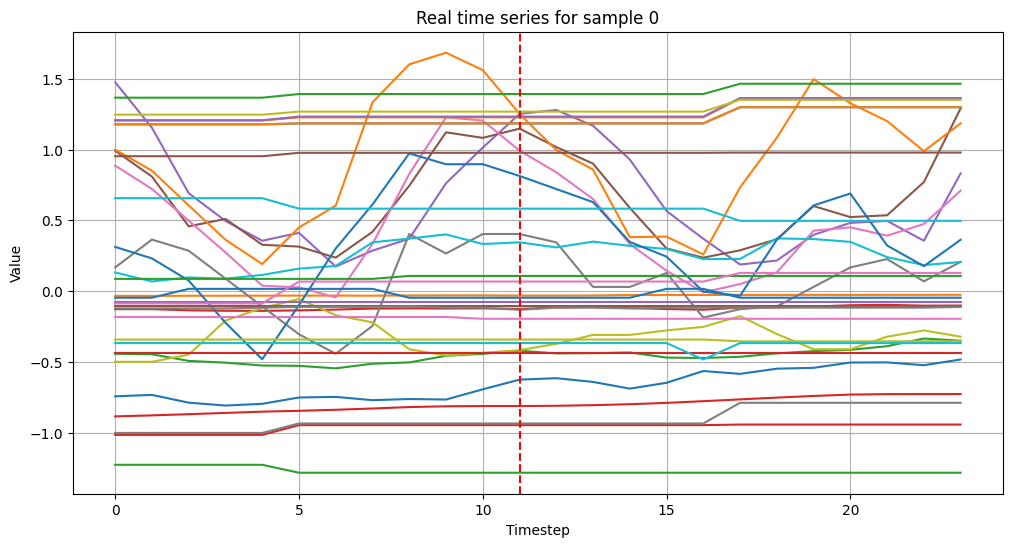

In [65]:
# x: (B, T, D)
B, T, D = 32, 14, 34
# for sample_idx in range(B):
sample_idx = 0

x_sample = output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.grid(True)
plt.show()

x_sample = xb.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Real time series for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.grid(True)
plt.show()

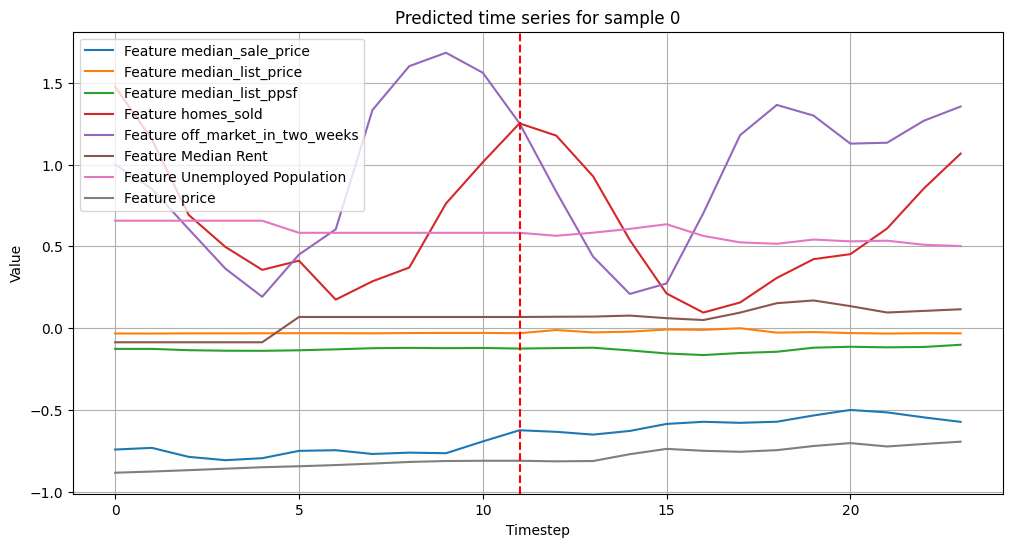

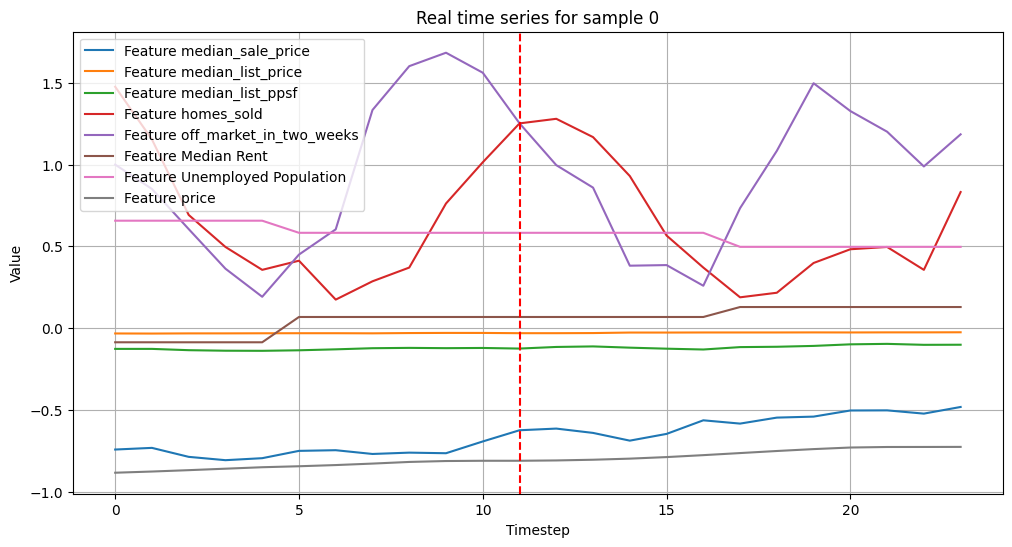

In [66]:
# x: (B, T, D)
B, T, D = 32, 14, 34
# for sample_idx in range(B):
sample_idx = 0

relevant_features_indeces = [0, 1, 3, 4, 11, 26, 29, 33]

x_sample = output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in relevant_features_indeces:
    plt.plot(x_sample[:, d], label=f'Feature {feature_index_mapping[d]}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

x_sample = xb.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in relevant_features_indeces:
    plt.plot(x_sample[:, d], label=f'Feature {feature_index_mapping[d]}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Real time series for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [83]:
criterion = nn.MSELoss()
test_loss_per_feature = torch.zeros(34)
test_loss = 0

with torch.no_grad():
    for x, timestamps, zipcode, year in test_loader:
        xr, xr_zipcodes, xr_years = retrieve_knn(
            x[:, 0:orig_len, :], 
            encoder_loaded, 
            faiss_index, 
            xr_target, 
            xr_zipcodes_db, 
            xr_years_db, 
            k=K, 
            device=device
        )
        x_img_tensor = get_img_tensors_batch_from_dirs(zipcode, year).to(device)
        x, xr, timestamps, xr_zipcodes, xr_years= x.to(device), xr.to(device), timestamps.to(device), xr_zipcodes.to(device), xr_years.to(device)
        xr_img_tensor = get_k_img_tensors_batch_from_dirs(xr_zipcodes, xr_years).to(device)
        x_in = x.detach().clone()
        x_in[:, 12:, :] = torch.rand_like(x_in[:, 12:, :])

        out = model(
            x_in,
            xr, 
            timestamps,
            None, 
            x_img_tensor, 
            xr_img_tensor,
            zipcode,
            xr_zipcodes
        )

        loss = criterion(out[:, orig_len:, :], x[:, orig_len:, :])

        batch_loss = 0
        for i in range(34):
            loss = criterion(out[:, orig_len:, i], x[:, orig_len:, i])
            loss_value = loss.item()
            test_loss_per_feature[i] += loss_value
            batch_loss += loss_value
        
        test_loss += batch_loss / 34  # Average per feature, per batch

avg_test_loss = test_loss / len(test_loader)
test_loss_per_feature = test_loss_per_feature / len(test_loader)

In [84]:
print(f"Test MSE = {avg_test_loss:.6f}")

Test MSE = 0.079485


In [85]:
criterion = nn.MSELoss()
val_loss_per_feature = torch.zeros(34)
val_loss = 0

with torch.no_grad():
    for x, timestamps, zipcode, year in val_loader:
        xr, xr_zipcodes, xr_years = retrieve_knn(
            x[:, 0:orig_len, :], 
            encoder_loaded, 
            faiss_index, 
            xr_target, 
            xr_zipcodes_db, 
            xr_years_db, 
            k=K, 
            device=device
        )
        x_img_tensor = get_img_tensors_batch_from_dirs(zipcode, year).to(device)
        x, xr, timestamps, xr_zipcodes, xr_years= x.to(device), xr.to(device), timestamps.to(device), xr_zipcodes.to(device), xr_years.to(device)
        xr_img_tensor = get_k_img_tensors_batch_from_dirs(xr_zipcodes, xr_years).to(device)
        x_in = x.detach().clone()
        x_in[:, 12:, :] = torch.rand_like(x_in[:, 12:, :])

        out = model(
            x_in,
            xr, 
            timestamps,
            None, 
            x_img_tensor, 
            xr_img_tensor,
            zipcode,
            xr_zipcodes
        )

        loss = criterion(out[:, orig_len:, :], x[:, orig_len:, :])

        batch_loss = 0
        for i in range(34):
            loss = criterion(out[:, orig_len:, i], x[:, orig_len:, i])
            loss_value = loss.item()
            val_loss_per_feature[i] += loss_value
            batch_loss += loss_value
        
        val_loss += batch_loss / 34  # Average per feature, per batch

avg_val_loss = val_loss / len(val_loader)
val_loss_per_feature = val_loss_per_feature / len(val_loader)

In [86]:
print(f"Val MSE = {avg_val_loss:.6f}")

Val MSE = 0.083717


In [87]:
mean_values = mean[0][0].tolist()
std_values = std[0][0].tolist()
test_mse_values = test_loss_per_feature.tolist()
val_mse_values = val_loss_per_feature.tolist()

# Create a DataFrame
data = []
for i in range(len(feature_index_mapping)):
    row = {
        'Feature': feature_index_mapping[i],
        'Mean': round(mean_values[i], 4),
        'Std': round(std_values[i], 4),
        'Test MSE': round(test_mse_values[i], 4),
        'Val MSE': round(val_mse_values[i], 4)
    }
    data.append(row)

df = pd.DataFrame(data, columns=["Feature", "Mean", "Std", "Test MSE", "Val MSE"])

df = df.sort_values(by=["Test MSE", "Val MSE"], ascending=[False, False]).reset_index(drop=True)

# Visualize
styled = df.style.set_caption("Feature-Level Summary Statistics") \
                 .format("{:.4f}", subset=["Mean", "Std", "Test MSE", "Val MSE"]) \
                 .background_gradient(subset=["Test MSE", "Val MSE"], cmap="Reds") \
                 .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}])

display(styled)

,Feature,Mean,Std,Test MSE,Val MSE
0,median_list_price,559273.7070,8929021.6001,0.7155,0.7525
1,avg_sale_to_list,0.9884,0.0317,0.3743,0.3741
2,median_dom,54.4115,78.9979,0.3184,0.3504
3,sold_above_list,0.2714,0.1921,0.3143,0.2969
4,median_list_ppsf,244.4712,561.0436,0.2486,0.3266
5,off_market_in_two_weeks,0.3191,0.2467,0.2005,0.2076
6,median_sale_price,453616.9734,245820.7292,0.1867,0.1864
7,median_ppsf,227.0334,115.0888,0.0649,0.0724
8,new_listings,81.7360,84.8837,0.0513,0.0482
9,inventory,50.4805,50.8368,0.0384,0.0375


Compared to the results of the previous notebook, the multimodal version of the model succeded in obtaing better predictions, even though we only achieved slightly better performances (0.079 vs 0.082 MSE on the test set, 0.083 vs 0.084 MSE on the validation set). In particular, as shown in the above table, the feature median_list_price registered a significant improvemnt in the Test MSE, keeping the Val MSE consistent with the results of the previous notebook. The feature still is the most prone to errors, due to the presence of outliers, as already specified. The feature median_list_ppsf (medial list price per square foot) registered a good improvement on the validation set, but got worse results on the test set, reaching a more balanced behaviour.

# Final Considerations

We successfully integrated the multimodality in the RATD model, achieving more accurate prediction, even though the imporvement was small and the performance of the two model are comparable. We expected the model to reach a lower error mostly on "visual" features such as: Total Housing Units, Schools, Malls, Restaurants, Hospitals, and the other similar features. Although some of them improved, like the hospital feature, their error was still so small to be negligible during the optimizion. It is to be considered that some images in the HouseTS are missing, so the dataset was incomplete and we had to reuse older images. For example we noticed that for zipcode 20001 are missing the images of the years 2019, 2020, 2022, 2023. <br/>
For future improvement we suggest to increase the dataset size, or as an alternative, trying to reconstruct the missing images using augmentations, for a more accurate forcasting.